In [2]:
import tensorflow as tf
import numpy as np
import os
import cv2
from tensorflow import keras as keras
from tensorflow.keras import *
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1

In [4]:
X_paths = os.listdir('/space/storage/homes/vrv/cellseg-cuda/processed_data/originals')
y_paths = os.listdir('/space/storage/homes/vrv/cellseg-cuda/processed_data/labels_3_classes')


In [5]:
# making the names of X_train and y_train correspond

X_paths.sort()
y_paths.sort()


In [6]:
nb_img=len(X_paths)
img_height=128
img_width=128
X = np.zeros((nb_img, img_height, img_width,1), dtype=np.uint8)
y = np.zeros((nb_img, img_height, img_width,1), dtype=np.uint8)


for i in range(len(X_paths)) : 
    img = imread('/space/storage/homes/vrv/cellseg-cuda/processed_data/originals/' + X_paths[i])
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    img = np.expand_dims(img, axis=-1)
    X[i]=img

for j in range(len(y_paths)) : 
    img = imread('/space/storage/homes/vrv/cellseg-cuda/processed_data/labels_3_classes/' + y_paths[j])
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    img = np.expand_dims(img, axis=-1)
    y[j]=img


In [7]:
#separating between train and test

n = len(X)
r = int(n*0.8)

X_train = X[:r]
X_test = X[r+1:]

y_train = y[:r]
y_test = y[r+1:]

In [8]:
print(len(X_train),len(y_train))

9016 9016


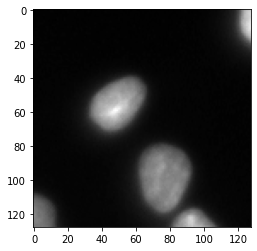

In [35]:
from PIL import Image as im
plt.imshow(X_train[243], cmap='gray')
plt.show()

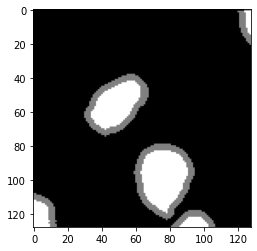

In [36]:
plt.imshow(y_train[243], cmap='gray')
plt.show()

### Model

In [9]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model2 = Model(inputs=[inputs], outputs=[outputs])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ["accuracy"])


In [ ]:
history = model2.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=50)

Train on 8114 samples, validate on 902 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Learning curve

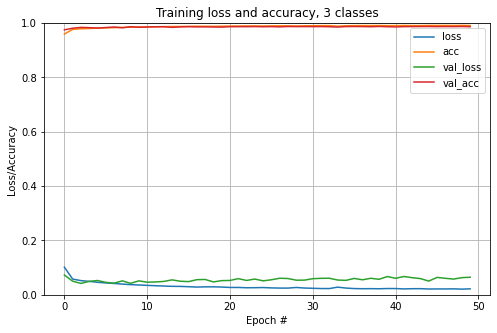

In [57]:
#learning curve

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) #set vertical range to [0-1]
plt.title("Training loss and accuracy, 3 classes")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
#plt.savefig('SN1_plot_results_2', tight_layout=False)
plt.show()

### Evaluating the model on the testing data

In [59]:
score = model2.evaluate(X_test, y_test, verbose = 0)
print("Loss : " + str(score[0]) + "  Accuracy : " + str(score[1]))

Loss : 0.0739406202956968  Accuracy : 0.98223937
